# World happiness index: finding regions

## Importing modules

Import the required modules.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

## Problem setting

Let's see whether it can be predicted from the numerical attributes whether a country is Western European or not. This is a classic binary classification problem.

## Importing training data

In [2]:
data_2015 = pd.read_csv('Data/world_happiness_2015.csv')

In [3]:
data_2015.describe()

,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,79.493671,5.375734,0.047885,0.846137,0.991046,0.630259,0.428615,0.143422,0.237296,2.098977
std,45.754363,1.145010,0.017146,0.403121,0.272369,0.247078,0.150693,0.120034,0.126685,0.553550
min,1.000000,2.839000,0.018480,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.328580
25%,40.250000,4.526000,0.037268,0.545808,0.856823,0.439185,0.328330,0.061675,0.150553,1.759410
50%,79.500000,5.232500,0.043940,0.910245,1.029510,0.696705,0.435515,0.107220,0.216130,2.095415
75%,118.750000,6.243750,0.052300,1.158448,1.214405,0.811013,0.549092,0.180255,0.309883,2.462415
max,158.000000,7.587000,0.136930,1.690420,1.402230,1.025250,0.669730,0.551910,0.795880,3.602140


## Analysis

Let's check how many countries each region has.  If there are too few, it makes no sense to include those in the training set.

In [4]:
region_count = pd.crosstab(index=data_2015['Region'], columns='count')
region_count

col_0,count
Region,
Australia and New Zealand,2
Central and Eastern Europe,29
Eastern Asia,6
Latin America and Caribbean,22
Middle East and Northern Africa,20
North America,2
Southeastern Asia,9
Southern Asia,7
Sub-Saharan Africa,40


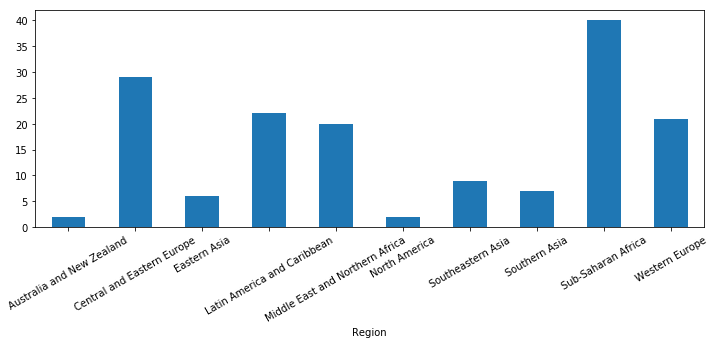

In [5]:
region_count.plot(kind='bar', legend=False, rot=30, figsize=(12, 4));

## Preprocess data

Define a class to extract data from a pandas DataFrame.

In [6]:
class FeatureSelector(BaseException, TransformerMixin):
    def __init__(self, feature_names):
        self._feature_names = feature_names
    def fit(self, X, Y=None):
        return self
    def transform(self, X):
        return X[self._feature_names].values

Define numerical atribute names.

In [7]:
num_attr_names = ['Economy (GDP per Capita)',
                  'Family', 'Health (Life Expectancy)', 'Freedom',
                  'Trust (Government Corruption)', 'Generosity',
                  'Dystopia Residual']

In [8]:
num_attrs_pipeline = Pipeline([
    ('select_num_attrs', FeatureSelector(num_attr_names)),
    ('scaler', MinMaxScaler()),
])

In [9]:
prepared_data = num_attrs_pipeline.fit_transform(data_2015)

Add a column to the data frame that has the value `True` if the country is in Western Europe, `False` otherwise.

In [10]:
data_2015['Western Europe'] = data_2015['Region'] == 'Western Europe'

## Training

Since the numerical attributes are reasonably described by a Gaussian distribution, we'll try to classify using a Gaussian Naive Bayes algorithm.

In [11]:
nb = GaussianNB()

In [12]:
nb.fit(prepared_data, data_2015['Western Europe'])

GaussianNB(priors=None)

In [13]:
nb.score(prepared_data, data_2015['Western Europe'])

0.93670886075949367

Let's try cross validation to gauge performance.

In [14]:
cross_val_score(nb, prepared_data, data_2015['Western Europe'],
                scoring='accuracy', cv=15)

array([ 0.5       ,  1.        ,  0.90909091,  0.81818182,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        0.9       ,  1.        ,  0.9       ,  0.9       ,  0.9       ])

Compute the confusion matrix.

In [15]:
confusion_matrix(data_2015['Western Europe'], nb.predict(prepared_data))

array([[130,   7],
       [  3,  18]])

So 7 countries that are not in Western Europe are classified into that region (false positives), while 3 Western European countries are classified as situated elsewhere (false negatives).

In [16]:
for country, region, pred_region in zip(data_2015['Country'],
                                        data_2015['Western Europe'],
                                        nb.predict(prepared_data)):
    if region != pred_region:
        print('{0}: {1} -> {2}'.format(country, region, pred_region))

Canada: False -> True
New Zealand: False -> True
Australia: False -> True
Israel: False -> True
United States: False -> True
Taiwan: False -> True
Slovenia: False -> True
Cyprus: True -> False
Portugal: True -> False
Greece: True -> False


A number of countries seem to have become "honorary" Western Europeans, while only three have been "demoted".

## Testing

Read the 2016 testing data.

In [17]:
data_2016 = pd.read_csv('Data/world_happiness_2016.csv')

In [18]:
data_2016['Western Europe'] = data_2016['Region'] == 'Western Europe'

In [19]:
prepared_test_data = num_attrs_pipeline.transform(data_2016)

In [20]:
nb.score(prepared_test_data, data_2016['Western Europe'])

0.86624203821656054

In [21]:
for country, region, pred_region in zip(data_2016['Country'],
                                        data_2016['Western Europe'],
                                        nb.predict(prepared_test_data)):
    if region != pred_region:
        print('{0}: {1} -> {2}'.format(country, region, pred_region))

Denmark: True -> False
Norway: True -> False
Finland: True -> False
Canada: False -> True
Netherlands: True -> False
New Zealand: False -> True
Australia: False -> True
Austria: True -> False
Germany: True -> False
Belgium: True -> False
Ireland: True -> False
Luxembourg: True -> False
United Kingdom: True -> False
Malta: True -> False
France: True -> False
Italy: True -> False
Japan: False -> True
North Cyprus: True -> False
Cyprus: True -> False
Portugal: True -> False
Greece: True -> False


In [22]:
confusion_matrix(data_2016['Western Europe'], nb.predict(prepared_test_data))

array([[132,   4],
       [ 17,   4]])

Oops, 17 Western European countries have left the region, this is clearly a rather bad classifier. Note that this is much less obvious when considering only the score.